In [301]:
from sympy import * 
from sympy.abc import * 
init_printing()

In [302]:
C_1, C_2, w_t, h_t, r_t, S_t, K_t, L_t, k_t, k_t1, r_t1, K_t1, L_t1, p_t, N_t = symbols(
    'C_1, C_2, w_t, h_t, r_t, S_t, K_t, L_t, k_t, k_{t+1}, r_{t+1}, K_{t+1}, L_{t+1}, p_t, N_t',
    real=True, positive=True
)
l = Symbol('lambda')
alpha = Symbol('alpha', positive=True)

### Решение задачи потребителя

#### Бюджетное ограничение

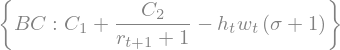

In [303]:
BC = C_1 + C_2 / (1 + r_t1) - h_t * w_t * (1 + sigma)
{Symbol("BC"): BC}

#### Функция полезности

In [304]:
U = ln(C_1) + psi * ln(1 - h_t) + beta * ln(C_2)
{Symbol("U"): U}

#### Лагранж

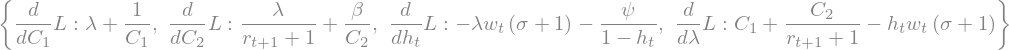

In [305]:
L = U + l * BC
consumer_control = (C_1, C_2, l, h_t)   # переменные, по которым мы дифференцируем
partials = {Derivative(Symbol("L"), i): diff(L, i) for i in consumer_control}
partials

#### Решение

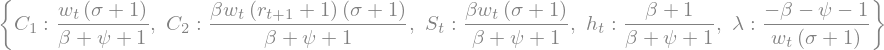

In [306]:
consumer_solution = solve(partials.values(), consumer_control, dict=True)[0]
s_expr = S_t - h_t * w_t * (1 + sigma) + C_1 
consumer_solution.update(solve(s_expr.subs(consumer_solution), S_t, dict=True)[0])
consumer_solution

### Решение задачи фирмы

#### Производственная функция

In [307]:
Y_t = K_t ** alpha * L_t ** (1 - alpha)
{Symbol("Y_t"): Y_t}

#### Функция прибыли

In [308]:
revenue = Y_t * p_t
costs = w_t * L_t + r_t * K_t 
pi = revenue - costs 
## you can also 
# pi = pu.subs({p_t: 1})
{Symbol("pi"): pi}

#### Дифференцирование функции прибыли

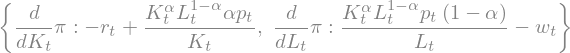

In [309]:
firm_control = (K_t, L_t)
partials = {Derivative(Symbol("pi"), i): diff(pi, i) for i in firm_control}
partials

#### Решение для фирмы

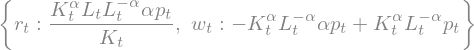

In [310]:
firm_solution = solve(partials.values(), (w_t, r_t))
firm_solution

In [311]:
solution = consumer_solution.copy()
solution.update(firm_solution)

**применим хитрость. нюанс, так сказать**

$$ k_t = \frac{K_t}{L_t} \Rightarrow \begin{cases} K_t = k_t \cdot L_t \\ L_t = \frac{K_t}{k_t}\end{cases}$$

In [312]:
y_t = (Y_t / L_t).subs({L_t: K_t / k_t, K_t: k_t * L_t},simultaneous=False).simplify()
{Symbol("y_t"): y_t}

In [313]:
intensive_solution = {k: 
    v.subs({L_t: K_t / k_t, K_t: k_t * L_t}, simultaneous=False).simplify() 
    for k, v in firm_solution.items()}
intensive_solution

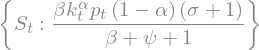

In [314]:
s_sol = {S_t: solution.get(S_t).subs(intensive_solution)}
intensive_solution.update(s_sol)
s_sol

In [320]:
vars_t1 = {K_t1: N_t * h_t * S_t, L_t1: h_t * N_t * (1 + n)}
vars_t1

#### Выразить $ k_{t+1} $

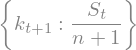

In [323]:
var_k1 = {k_t1: (K_t1 / L_t1).subs(vars_t1)}
intensive_solution.update(var_k1)
var_k1

#### Выразить $ k_{t+1}$  через $ k_t $

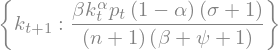

In [328]:
dynamic_k1 = {k_t1: var_k1.get(k_t1).subs(s_sol)}
dynamic_k1

#### Стационарное состояние

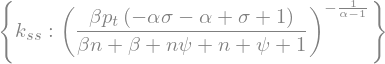

In [348]:
k_ss = Symbol("k_{ss}", positive=True)
ss = {k_ss: solve(dynamic_k1.get(k_t1) - k_t, k_t)[0]}
ss

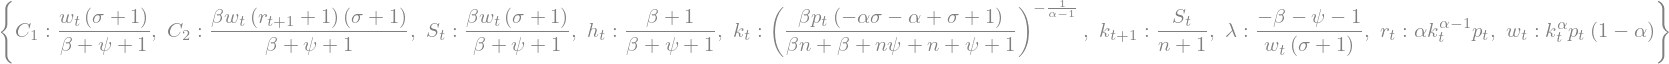

In [362]:
total_solution = intensive_solution
total_solution.update(consumer_solution)
total_solution.update({k_t: ss.get(k_ss)})
total_solution

In [389]:
values = {
    beta: 0.6, 
    alpha: 0.5, 
    n: 0.03, 
    sigma: 0.15, 
    psi: 0.3,
    p_t: 1, 
    r_t1: r_t
}

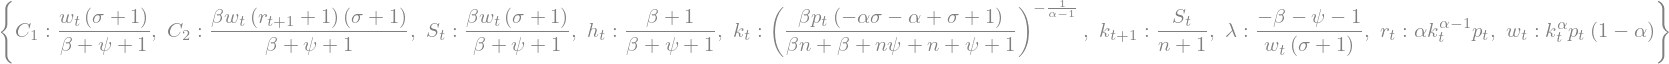

In [390]:
total_solution

In [401]:
sol = {k: v.subs(total_solution).subs(values) for k, v in total_solution.items()}
answer = {k: v.subs(sol).round(3) for k, v in sol.items()}
answer

In [400]:
answer